
# Forced Alignment with Wav2Vec2



In [1]:
import os
data_path = './data/ST-CMDS-20170001_1-OS/'
files = os.listdir(data_path)
file_names = []
for file in files:
    if file.split('.')[1] == 'txt':
        file_names.append(file.split('.')[0])
dataset_file_num = len(file_names)
dataset_file_num

102600

In [2]:
get_audio = lambda x: data_path+file_names[x]+'.wav' if x < dataset_file_num else None
get_text = lambda x: open(data_path+file_names[x]+'.txt', "r").read() if x < dataset_file_num else None

In [45]:
# 测试是否有文件兼容性问题
min = 100000
max = 0
for i in range(dataset_file_num):
    text = get_text(i)
    if len(text) < min:
        min = len(text)
    if len(text) > max:
        max = len(text)
    if len(text) == 1:
        print(i, text)
min, max

963 威


(1, 22)

In [3]:
# fix Audio for vscode notebook
def Audio(path):
    os.popen(f'cp {path} ./audio-temp.wav') 
    print('please check ./audio-temp.wav for audio')

In [44]:
import random
# from IPython.display import Audio

rand_id = 963 # random.randint(0, dataset_file_num-1)

audio_file = get_audio(rand_id)

sentence = get_text(rand_id)

print(rand_id, sentence)
Audio(audio_file)

963 威
please check ./audio-temp.wav for audio


## Preparation

First we import the necessary packages, and fetch data that we work on.




In [15]:
# %matplotlib inline

import os
from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)
Audio(SPEECH_FILE)

1.11.0
0.11.0
cpu
please check ./audio-temp.wav for audio


## Generate frame-wise label probability

The first step is to generate the label class porbability of each aduio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [7]:
bundle = torchaudio.pipelines.VOXPOPULI_ASR_BASE_10K_EN
model = bundle.get_model().to(device)
labels = bundle.get_labels()

model.aux

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_voxpopuli_base_10k_asr_en.pt" to /home/bh2283/.cache/torch/hub/checkpoints/wav2vec2_voxpopuli_base_10k_asr_en.pt
100.0%


Linear(in_features=768, out_features=28, bias=True)

In [8]:

with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

In [9]:
emission.shape

torch.Size([169, 28])

## Do CTC Decoder

In [10]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

class NaiveCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        # indices = torch.unique_consecutive(indices, dim=-1)
        # indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [11]:
labels = bundle.get_labels()
# labels = list(labels)
look_up = {s: i for i, s in enumerate(labels)} # 字母转数字
# labels = {i: s for i, s in enumerate(labels)} # 数字转字母

In [12]:
print("bundle labels", labels)

bundle labels ('-', '|', 'e', 't', 'o', 'i', 'a', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'u', 'm', 'p', 'f', 'g', 'w', 'y', 'b', 'v', 'k', 'x', 'j', 'q', 'z')


In [13]:
# indices = torch.argmax(emission, dim=-1)  # [num_seq,]
# torch.unique_consecutive(indices, dim=0)

In [14]:
decoder = GreedyCTCDecoder(labels=labels)
transcript = decoder(emission)
transcript

'i|had|that|kery|ask|tha|he|beside|me|at|this|moment'

# Transfer Learning in Chinese

In [14]:
# ! pip install pypinyin

创建中文注音label，不要让模型直接预测拼音，而是改为预测音素

In [16]:
initial_table = ['b', 'p', 'm', 'f',
                'd', 't', 'n', 'l',
                'g', 'k', 'h',
                'j', 'q', 'x',
                'zh', 'ch', 'sh', 'r', 'z', 'c', 's']

finals_table = [['i', 'u', 'v'], # 可以与下面的配成 iao, ue
                ['a', 'o', 'e', 
                'ai', 'ei', 'ao',
                'ou', 'an', 'en',
                'ang', 'eng', 'ong',
                'er']]

# labels = ['-','|']+initial_table + finals_table[0] + finals_table[1]
# look_up = {s: i for i, s in enumerate(labels)} # 字母转数字

In [17]:
print(labels, len(labels))

('-', '|', 'e', 't', 'o', 'i', 'a', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'u', 'm', 'p', 'f', 'g', 'w', 'y', 'b', 'v', 'k', 'x', 'j', 'q', 'z') 28


In [18]:
decoder = GreedyCTCDecoder(labels=labels)

In [19]:
import pypinyin
from pypinyin import lazy_pinyin, Style

In [20]:
lazy_pinyin('林允儿嗯', strict=True, style=Style.INITIALS, errors=lambda x: u'-'),\
    lazy_pinyin('林云儿嗯', strict=True, style=Style.FINALS, errors=lambda x: u'-')

(['l', '', '', ''], ['in', 'vn', 'er', ''])

In [24]:
def chinese2pinyin(text):
    initials = lazy_pinyin(text, strict=True, style=Style.INITIALS, errors=lambda x: u'')
    finals = lazy_pinyin(text, strict=True, style=Style.FINALS, errors=lambda x: u'')
    pinyin = ''
    for i in range(len(finals)):
        pinyin+='|'
        if (initials[i] == '-'):
            continue
        pinyin+=initials[i]
        pinyin+=finals[i]
        if finals[i] == '':
            pinyin+='n'
    if pinyin[-1] == '|':
        pinyin = pinyin[:-1]
    return pinyin[1:].lower().replace('w','u')

''.join(chinese2pinyin("绿色的温水，迂回的乌烟，流过。啊！哇！嗯，问妞儿归去."))

'lv|se|de|uen|shuei|v|huei|de|u|ian|liou|guo|a|ua|n|uen|niou|er|guei|qv'

In [25]:
def label2id(str):
    return [look_up[i] for i in str]

def id2label(idcs):
    return [labels[i] for i in idcs]

# label2id(chinese2pinyin("美好，我很开心儿！")), ','.join(id2label(label2id(chinese2pinyin("美好，我很开心！"))))

In [26]:
from torch.utils.data import Dataset, DataLoader

In [32]:
sr = 16000
class AudioDataset(Dataset):

    def __init__(self, file_names, data_path, sample_rate=16000, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file_names = file_names
        self.root_dir = data_path
        self.transform = transform
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform.to(device)
        
        if sample_rate != sr:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        
        audio_content = get_text(idx)
        
        sample = {'audio': waveform, 'text': audio_content}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [33]:
audio_dataset = AudioDataset(file_names, data_path, sample_rate=16000)
audio_dataset[0]

{'audio': tensor([[ 4.8828e-04,  4.8828e-04,  2.4414e-04,  ...,  0.0000e+00,
          -6.1035e-05, -4.5776e-04]]),
 'text': '那爽死了呵呵你军训完了吗'}

In [70]:
# with torch.no_grad():
#     i = 1
#     sample = audio_dataset[i]
#     print(i, sample['audio'].shape, sample['text'])
    
#     waveform = sample['audio']
#     emissions, _ = model(waveform.to(device))
#     emissions = torch.log_softmax(emissions, dim=-1)

# emission = emissions[0].cpu().detach().unsqueeze(1)

In [71]:
# emission.shape, emission[90][0]

In [36]:
model = bundle.get_model()
for param in model.parameters():
    param.requires_grad = False
# model.aux = torch.nn.Linear(in_features=model.aux.in_features, out_features=model.aux.out_features, bias=True)
# torch.nn.init.xavier_normal(model.aux.weight)
for param in model.aux.parameters():
    param.requires_grad = True
model = model.to(device)

In [37]:
with torch.no_grad():
    i = 2
    sample = audio_dataset[i]
    print(i, sample['audio'].shape, sample['text'])

    waveform = sample['audio']
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1).permute(1, 0, 2)

    ctc_loss = torch.nn.CTCLoss(zero_infinity=True)
    target = torch.tensor([label2id(chinese2pinyin(sample['text']))])
    # target = 
    print(emissions.shape, target.shape)
    Input_lengths = (emissions.shape[0],)
    Target_lengths = (target.shape[-1],)
    loss = ctc_loss(emissions, target, Input_lengths, Target_lengths)

emission = emissions.cpu().detach()
transcript = decoder(emission)
transcript, ','.join(chinese2pinyin(sample['text'])), loss.item()

2 torch.Size([1, 61664]) 领导都准备暗示让我辞职
torch.Size([192, 1, 28]) torch.Size([1, 44])


('leann||no||thoughh||turn||they|antalo|what|s',
 'l,i,n,g,|,d,a,o,|,d,o,u,|,z,h,u,e,n,|,b,e,i,|,a,n,|,s,h,i,|,r,a,n,g,|,u,o,|,c,i,|,z,h,i',
 2.7934839725494385)

In [74]:
# chinese2pinyin(sample['text'])

In [76]:
id = label2id(chinese2pinyin(sample['text']))
len(id),print(id)

[11, 7, 4, 6, 1, 8, 13, 4, 1, 28, 8, 4, 6, 1, 25, 7, 4, 6, 1, 1, 18, 4, 6, 1, 14, 4, 5, 1, 8, 4, 5, 1, 12, 2, 1, 14, 4, 1, 1, 28, 8, 2, 1, 28, 8, 5, 13, 1, 20, 4, 1, 9, 8, 4, 6, 1, 27, 22, 1, 1, 4, 1, 1, 27, 22, 1, 14, 4]


(68, None)

In [77]:
len(audio_dataset)

2400

In [78]:
model.aux

Linear(in_features=768, out_features=29, bias=True)

In [79]:
# optimizer = torch.optim.SGD(model.aux.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.aux.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.aux.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Try to save checkpoint

In [80]:
from os.path import exists

LOAD_PATH = './checkpoint/model.pt'
if exists(LOAD_PATH):
    print('file',LOAD_PATH,'exist, load checkpoint...')
    checkpoint = torch.load(LOAD_PATH)
    model.aux.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(epoch, loss)

In [81]:
# checkpoint = torch.load(PATH)
# model.aux.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(epoch, loss)

使用DataLoader按照批次加载

In [82]:
batch_size = 8

def collate_wrapper(batch):
    audio_list = [item['audio'] for item in batch]
    target_list = [label2id(chinese2pinyin(item['text'])) for item in batch]
    return {'audio': audio_list, 'target': target_list}

dataloader = DataLoader(audio_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=collate_wrapper)

In [83]:
dataloader

In [84]:
def test(k):
    model.eval()
    with torch.no_grad():
        for i in range(k):
            sample = audio_dataset[i]
            print(i, sample['audio'].shape, sample['text'])
            waveform = sample['audio']
            emissions, _ = model(waveform.to(device))
            emissions = torch.log_softmax(emissions, dim=-1)
            emission = emissions[0].cpu().detach()
            transcript = decoder(emission)
            print('transcript:', transcript, NaiveCTCDecoder(labels)(emission))

In [85]:
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/model_{EPOCH}_{LOSS}.pt"
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.aux.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [86]:
for epoch in range(1):
    model.train()
    for i_batch, sample_batched in enumerate(dataloader):
        for i in range(batch_size):  # Cannot run in batch, only 1 by 1
            optimizer.zero_grad()
            # Step 1. Prepare Data
            waveform = sample_batched['audio'][i]
            target = sample_batched['target'][i]

            # Step 2. Run our forward pass
            emissions, _ = model(waveform.to(device))
            emissions = torch.nn.functional.log_softmax(emissions, dim=-1).permute(1, 0, 2)
            target = torch.tensor([target]).to(device)
            loss = ctc_loss(emissions, target, (emissions.shape[0],), (target.shape[-1],))

            # Step 2. Run our backward pass
            loss.backward()
            optimizer.step()

        if i_batch % (400 // batch_size) == 0:
            print('epoch', epoch, 'loss', loss.item())
    scheduler.step()
    save_checkpoint(epoch, loss.item())
    test(3) # run some sample prediction and see the result

epoch 0 loss 3.1583445072174072


KeyboardInterrupt: 

In [65]:
with torch.no_grad():
    i = 1
    sample = audio_dataset[i]
    print(i, sample['audio'].shape, sample['text'])

    waveform = sample['audio']
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()
transcript = decoder(emission)
transcript, NaiveCTCDecoder(labels)(emission)

1 torch.Size([1, 44928]) 初次见面请多多关照。


('ZAO|SHE|JIA|I|JIN|DO|DO|BAN|A|',
 '----------Z------AA-O--------|SH--E--|||J---I--A---||---I---------||----J-----I-N---||------D---OO----||D---OO---||B---A-NN-----|---A----|--')

In [ ]:
# model.train()
# for epoch in range(10):
#     for i in range(len(audio_dataset)):
#         optimizer.zero_grad()

#         sample = audio_dataset[i]
        
#         # Step 1. Prepare Data
#         waveform = sample['audio']
#         text = sample['text']
        
#         # Step 2. Run our forward pass
#         emissions, _ = model(waveform.to(device))
#         emissions = torch.nn.functional.log_softmax(emissions, dim=-1).permute(1, 0, 2)
#         target = torch.tensor([label2id(chinese2pinyin(sample['text']))])
#         loss = ctc_loss(emissions, target, (emissions.shape[0],), (target.shape[-1],))
        
#         # Step 2. Run our backward pass
#         loss.backward()
#         optimizer.step()
        
#         if i%400==0: # and i == 0:
#           print(epoch, loss.item())

### Visualization



('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


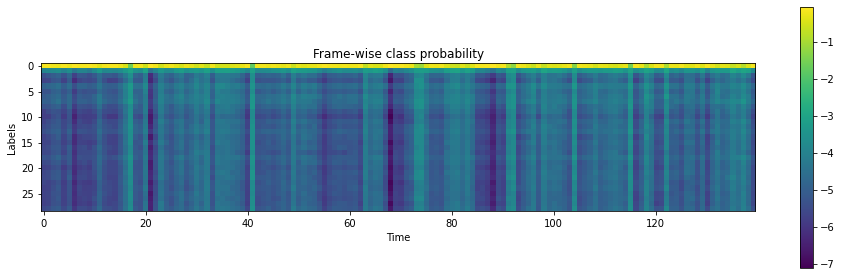

In [32]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

## Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">

Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )$

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[`distill.pub <https://distill.pub/2017/ctc/>`__])




In [41]:
transcript = transcript
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame + 1, num_tokens + 1), -float("inf"))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('A', 7), ('N', 9), ('S', 12), ('E', 5), ('G', 21), ('N', 9), ('I', 10), ('N', 9), ('T', 6), ('I', 10), ('E', 5), ('N', 9), ('|', 4), ('W', 18), ('A', 7), ('S', 12), ('|', 4), ('Y', 22), ('O', 8), ('U', 16), ('R', 13), ('|', 4), ('E', 5), ('A', 7), ('T', 6), ('|', 4), ('I', 10), ('N', 9), ('|', 4), ('K', 26), ('I', 10), ('N', 9), ('D', 14), ('|', 4), ('O', 8), ('U', 16), ('T', 6), ('W', 18), ('O', 8), ('T', 6), ('O', 8), ('|', 4), ('T', 6), ('H', 11), ('A', 7), ('S', 12), ('|', 4), ('U', 16), ('S', 12), ('U', 16), ('A', 7), ('L', 15), ('|', 4)]


### Visualization



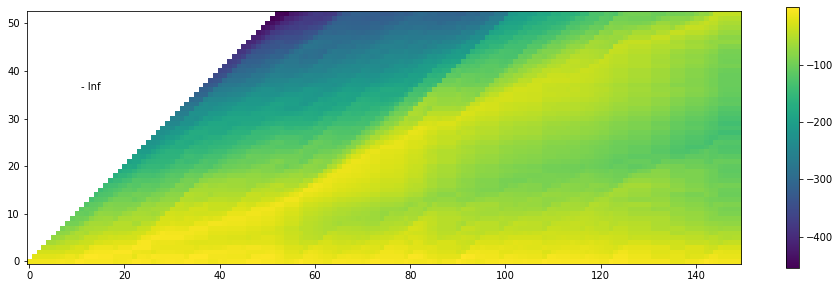

In [42]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [43]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=10, score=0.6301562190055847), Point(token_index=0, time_index=11, score=0.9929498434066772), Point(token_index=1, time_index=12, score=0.4440693259239197), Point(token_index=1, time_index=13, score=0.7136215567588806), Point(token_index=1, time_index=14, score=0.9036999940872192), Point(token_index=1, time_index=15, score=0.6954922676086426), Point(token_index=1, time_index=16, score=0.6062353849411011), Point(token_index=1, time_index=17, score=0.9770826101303101), Point(token_index=2, time_index=18, score=0.8408170342445374), Point(token_index=2, time_index=19, score=0.9683014154434204), Point(token_index=2, time_index=20, score=0.989621639251709), Point(token_index=2, time_index=21, score=0.9914264678955078), Point(token_index=3, time_index=22, score=0.5883039832115173), Point(token_index=3, time_index=23, score=0.6977431178092957), Point(token_index=4, time_index=24, score=0.669330894947052), Point(token_index=4, time_index=25, score=0.701433718204

### Visualization



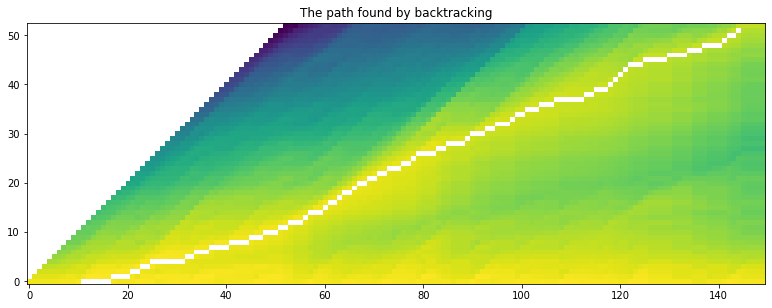

In [44]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

Looking good. Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [45]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

A	(0.81): [   10,    12)
N	(0.72): [   12,    18)
S	(0.95): [   18,    22)
E	(0.64): [   22,    24)
G	(0.69): [   24,    26)
N	(0.74): [   26,    33)
I	(0.50): [   33,    35)
N	(0.92): [   35,    38)
T	(0.92): [   38,    42)
I	(0.94): [   42,    46)
E	(0.90): [   46,    49)
N	(0.90): [   49,    52)
|	(0.80): [   52,    54)
W	(0.99): [   54,    57)
A	(0.99): [   57,    58)
S	(0.70): [   58,    61)
|	(0.96): [   61,    62)
Y	(0.97): [   62,    64)
O	(0.94): [   64,    65)
U	(0.88): [   65,    67)
R	(0.67): [   67,    68)
|	(0.77): [   68,    70)
E	(0.55): [   70,    72)
A	(0.94): [   72,    74)
T	(0.87): [   74,    77)
|	(0.83): [   77,    79)
I	(0.84): [   79,    80)
N	(0.49): [   80,    84)
|	(0.70): [   84,    86)
K	(0.92): [   86,    90)
I	(0.56): [   90,    91)
N	(0.73): [   91,    94)
D	(0.75): [   94,    96)
|	(0.85): [   96,    99)
O	(0.76): [   99,   100)
U	(0.76): [  100,   102)
T	(0.63): [  102,   105)
W	(0.74): [  105,   108)
O	(0.61): [  108,   114)
T	(0.80): [  114,   116)


### Visualization



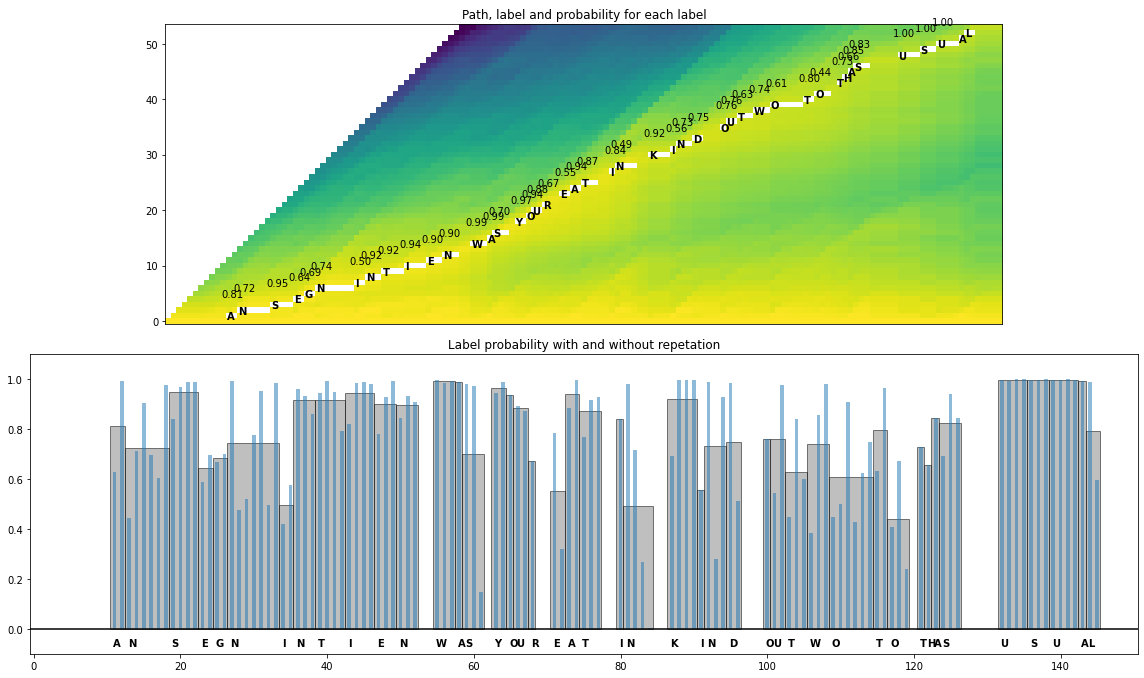

In [46]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

Looks good. Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [47]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

ANSEGNINTIEN	(0.81): [   10,    52)
WAS	(0.87): [   54,    61)
YOUR	(0.89): [   62,    68)
EAT	(0.80): [   70,    77)
IN	(0.56): [   79,    84)
KIND	(0.79): [   86,    96)
OUTWOTO	(0.65): [   99,   119)
THAS	(0.79): [  120,   126)
USUAL	(0.97): [  131,   145)


### Visualization



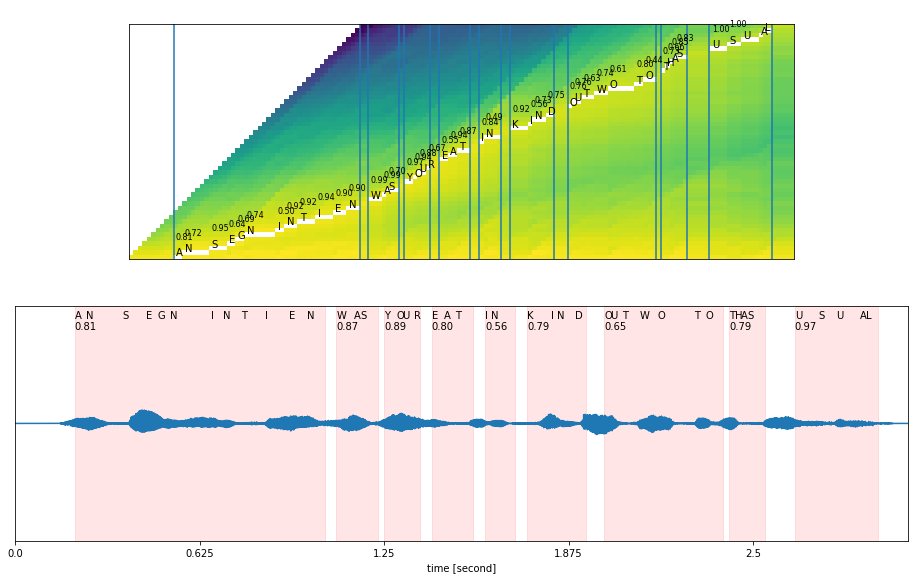

In [48]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()


# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    filename = f"_assets/{i}_{word.label}.wav"
    torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    return IPython.display.Audio(filename)

In [49]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

ANSEGNINTIEN|WAS|YOUR|EAT|IN|KIND|OUTWOTO|THAS|USUAL|


In [50]:
display_segment(0)

ANSEGNINTIEN (0.81): 0.202 - 1.048 sec


In [56]:
display_segment(1)

WAS (0.87): 1.089 - 1.230 sec


In [52]:
display_segment(2)

YOUR (0.89): 1.250 - 1.371 sec


In [53]:
display_segment(3)

EAT (0.80): 1.411 - 1.552 sec


In [54]:
display_segment(4)

IN (0.56): 1.593 - 1.693 sec


In [55]:
display_segment(5)

KIND (0.79): 1.734 - 1.935 sec


In [19]:
display_segment(6)

AT (0.66): 2.515 - 2.575 sec


In [20]:
display_segment(7)

THIS (0.70): 2.615 - 2.776 sec


In [21]:
display_segment(8)

MOMENT (0.97): 2.857 - 3.098 sec


## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


